In [3]:
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql.functions import col
import sys
import os
from pyspark.sql.functions import lit
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
from pyspark.sql import Window
from pyspark.sql.functions import col, expr, percentile_approx
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import col, collect_list, expr
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
!pip install --user tqdm
# conf=SparkConf().
from time import perf_counter

In [4]:
from tqdm import tqdm

In [6]:
spark = SparkSession.builder.appName("aarav").master("spark://cm027:46416").config("spark.kryoserializer.buffer.max", "1g").getOrCreate()
sc = spark.sparkContext

In [7]:
data_dir = '/scratch/work/courses/DSGA1004-2021/listenbrainz'

def GetDataset(spark, version='small', split='train'):
    if version == 'small':
        prefix = '_small'
    else:
        prefix = ''

    interactions = spark.read.parquet(os.path.join(data_dir, f'interactions_{split}{prefix}.parquet'))
    tracks = spark.read.parquet(os.path.join(data_dir, f'tracks_{split}{prefix}.parquet'))
    users = spark.read.parquet(os.path.join(data_dir, f'users_{split}{prefix}.parquet'))

    return interactions, tracks, users

In [8]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

def preprocess(df_tracks, df_interactions):
    # Join the dataframes and select required columns
    df_tracks = df_tracks.select(['recording_msid', 'recording_mbid'])
    initial_joined_df = df_interactions.join(df_tracks, on='recording_msid').select(
        'user_id',
        F.unix_timestamp('timestamp').cast(DoubleType()).alias('timestamp'),
        F.when(F.col("recording_mbid").isNull(), F.col("recording_msid"))
        .otherwise(F.col("recording_mbid")).alias("recording_id")
    )
  
    return initial_joined_df


In [9]:
def get_stats_df(df, value_col, variable_col):
    return df.select(
        lit(variable_col).alias("Metric"),
        col(f"mean_{value_col}").alias("mean"),
        col(f"std_{value_col}").alias("stddev"),
        col(f"min_{value_col}").alias("min"),
        col(f"max_{value_col}").alias("max")
    )
def getStats(result_df):
    result_df = result_df.cache()

    # Calculate user counts per interaction
    user_counts_per_interaction = result_df.groupBy("recording_id").agg(
        F.count("user_id").alias("user_count"),
        F.countDistinct("user_id").alias("unique_user_count")
    )

    # Calculate interaction counts per user
    interaction_counts_per_user = result_df.groupBy("user_id").agg(
        F.count("recording_id").alias("interaction_count"),
        F.countDistinct("recording_id").alias("unique_interaction_count")
    )

    # Calculate the statistics DataFrames
    users_per_interaction_stats = user_counts_per_interaction.agg(
        F.mean("user_count").alias("mean_user_count"),
        F.stddev("user_count").alias("std_user_count"),
        F.min("user_count").alias("min_user_count"),
        F.max("user_count").alias("max_user_count"),
        F.mean("unique_user_count").alias("mean_unique_user_count"),
        F.stddev("unique_user_count").alias("std_unique_user_count"),
        F.min("unique_user_count").alias("min_unique_user_count"),
        F.max("unique_user_count").alias("max_unique_user_count")
    )
    interactions_per_user_stats = interaction_counts_per_user.agg(
        F.mean("interaction_count").alias("mean_interaction_count"),
        F.stddev("interaction_count").alias("std_interaction_count"),
        F.min("interaction_count").alias("min_interaction_count"),
        F.max("interaction_count").alias("max_interaction_count"),
        F.mean("unique_interaction_count").alias("mean_unique_interaction_count"),
        F.stddev("unique_interaction_count").alias("std_unique_interaction_count"),
        F.min("unique_interaction_count").alias("min_unique_interaction_count"),
        F.max("unique_interaction_count").alias("max_unique_interaction_count")
    )

    # Reformat the statistics DataFrames and combine them
    users_per_interaction_df = get_stats_df(users_per_interaction_stats, "user_count", "users_per_interaction")
    unique_users_per_interaction_df = get_stats_df(users_per_interaction_stats, "unique_user_count", "unique_users_per_interaction")
    interactions_per_user_df = get_stats_df(interactions_per_user_stats, "interaction_count", "interactions_per_user")
    unique_interactions_per_user_df = get_stats_df(interactions_per_user_stats, "unique_interaction_count", "unique_interactions_per_user")

    # Combine the DataFrames
    stats_df = users_per_interaction_df.unionByName(unique_users_per_interaction_df) \
        .unionByName(interactions_per_user_df) \
        .unionByName(unique_interactions_per_user_df)

    return stats_df

In [10]:
def plot_unique_users_per_interaction_histogram_large(df, num_bins=50):
    # Calculate unique user counts per interaction
    user_counts_per_interaction = df.groupBy("recording_id").agg(
        F.countDistinct("user_id").alias("unique_user_count")
    )

    # Determine the range of unique user counts
    min_user_count, max_user_count = user_counts_per_interaction.agg(
        F.min("unique_user_count"), F.max("unique_user_count")
    ).collect()[0]

    # Create the Bucketizer
    bucketizer = Bucketizer(
        splits=[i for i in range(int(min_user_count), int(max_user_count) + 2)], 
        inputCol="unique_user_count", 
        outputCol="buckets"
    )

    # Apply the Bucketizer to the data
    bucketed_data = bucketizer.transform(user_counts_per_interaction)

    # Calculate the histogram data
    histogram_data = bucketed_data.groupBy("buckets").agg(count("*").alias("frequency")).orderBy("buckets").collect()

    # Extract bucket edges and frequencies for plotting
    bucket_edges = [row["buckets"] for row in histogram_data]
    frequencies = [row["frequency"] for row in histogram_data]

    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(bucket_edges, frequencies, width=1, edgecolor='black')
    plt.xlabel('Unique Users per Interaction')
    plt.ylabel('Frequency')
    plt.title('Histogram of Unique Users per Interaction')
#     plt.xscale('log')
    plt.yscale('log')
    plt.show()


In [11]:
df_interactions, df_tracks, df_users = GetDataset(spark, version='')
df_interactions_test, df_tracks_test, df_users_test = GetDataset(spark, version='', split='test')
df = preprocess(df_tracks, df_interactions)
df_test = preprocess(df_tracks_test, df_interactions_test)

In [18]:
# min_user_id = df_interactions.select(F.min("user_id")).first()[0]
# max_user_id = df_interactions.select(F.max("user_id")).first()[0]
minmaxusers = df.agg(
    F.min('user_id').alias('min'),
    F.max('user_id').alias('max'),
    F.count('user_id').alias('count')).collect()[0]
# df.write.parquet('Preprocessed_train.parquet')

In [10]:
minmaxusers

Row(min=1, max=22705, count=179466123)

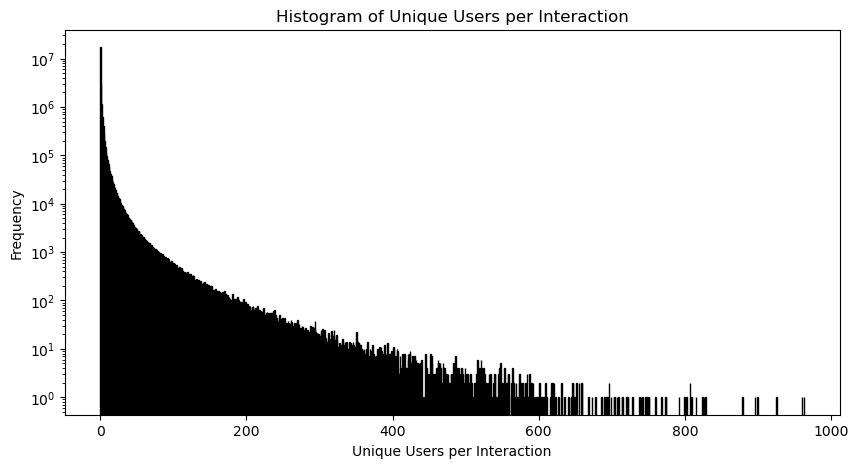

In [11]:
plot_unique_users_per_interaction_histogram_large(df)

In [12]:
df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- timestamp: double (nullable = true)
 |-- recording_id: string (nullable = true)



In [15]:
r = getStats(df)

In [16]:
r.show()

+--------------------+------------------+------------------+---+-------+
|              Metric|              mean|            stddev|min|    max|
+--------------------+------------------+------------------+---+-------+
|users_per_interac...| 7.511809915250789|40.348298310841024|  1|   7549|
|unique_users_per_...| 2.549577970060603| 8.287003868331272|  1|    964|
|interactions_per_...|22691.379820457707| 36651.96517909728|  1|1316412|
|unique_interactio...| 7701.664812239221| 15110.85902553801|  1| 937299|
+--------------------+------------------+------------------+---+-------+



In [17]:
def split_on_timestamp(final_joined_df, threshold = 0.6, drop_low_interactions = False):
    # Calculate the 60th percentile timestamp for each user
    user_thresholds = (
        final_joined_df.groupBy("user_id")
        .agg(percentile_approx("timestamp", threshold).alias("threshold"))
    )

    # Join the original DataFrame with the user thresholds
    joined_df = final_joined_df.join(user_thresholds, on="user_id")

    # Split the data into train and test based on the threshold
    df_train = joined_df.filter(col("timestamp") <= col("threshold")).drop("threshold")
    df_test = joined_df.filter(col("timestamp") > col("threshold")).drop("threshold")
#     if(drop_low_interactions):
#         unique_users_per_interaction = df_train.groupBy('recording_id').agg(
#             F.countDistinct('user_id').alias('users'))
#         unique_users_per_interaction = unique_users_per_interaction.filter(col('users') > 10)
#         df_train = df_train.join(unique_users_per_interaction.select('recording_id'), on='recording_id') 
        
    return df_train, df_test


In [18]:
def split_on_interaction(final_joined_df, split = 0.8):
    # Split distinct user_ids into train and test sets
    partition = final_joined_df.select('user_id').distinct().randomSplit([split, 1-split], seed=1234)

    train_users = [row.user_id for row in partition[0].collect()]
    test_users = [row.user_id for row in partition[1].collect()]

    # Use DataFrame API to filter the data based on user_ids
    train = final_joined_df.filter(col("user_id").isin(train_users))
    test = final_joined_df.filter(col("user_id").isin(test_users))

    return train, test

In [19]:
def filter_low_interactions(df):
    unique_users_per_interaction=df.groupBy('recording_id').agg(
            F.countDistinct('user_id').alias('users'))
    unique_users_per_interaction = unique_users_per_interaction.filter(col('users') > 20)
    df = df.join(unique_users_per_interaction.select('recording_id'), on='recording_id')
    
    unique_interactions_per_user=df.groupBy('user_id').agg(
            F.countDistinct('recording_id').alias('unique_listens'))
    unique_interactions_per_user=unique_interactions_per_user.filter(col('unique_listens')>20)
    
    df=df.join(unique_interactions_per_user.select('user_id'),on='user_id')
    return df

In [22]:
df = filter_low_interactions(df)
df_test = filter_low_interactions(df_test)

In [16]:
combined_df = df.union(df_test)

In [17]:
# Create a StringIndexer instance
indexer = StringIndexer(inputCol="recording_id", outputCol="recording_id_index", handleInvalid="keep")

# Fit the indexer on your train data and transform both train and test data
indexer_model = indexer.fit(combined_df)
# indexer_model = indexer.fit(df_test)
df_indexed = indexer_model.transform(df)

In [18]:
df_test_indexed = indexer_model.transform(df_test)

In [23]:
train, test = split_on_timestamp(df, threshold = 0.8)

In [22]:
train.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- recording_id: string (nullable = true)
 |-- timestamp: double (nullable = true)
 |-- recording_id_index: double (nullable = false)



In [23]:
test.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- recording_id: string (nullable = true)
 |-- timestamp: double (nullable = true)
 |-- recording_id_index: double (nullable = false)



In [24]:
def GetGroupedByUserItem(df):
    df = df.groupBy("recording_id_index", "user_id").agg(count("*").alias("rating"))
    df_total=df.groupBy("user_id").agg(F.sum("rating").alias("total"))
    #df_total=df_total.select("user_id","total")
    df_joined=df.join(df_total,on='user_id')
    df_joined=df_joined.withColumn("avg_rating",(col("rating")/col("total")))
    return df_joined.select("user_id","avg_rating","recording_id_index")

In [21]:
train_als,test_als = GetGroupedByUserItem(df_indexed),GetGroupedByUserItem(df_test_indexed)

In [22]:
!rm -r train_als.parquet

In [23]:
train_als.write.parquet('train_als.parquet')

23/05/16 11:41:22 WARN DAGScheduler: Broadcasting large task binary with size 40.5 MiB


In [24]:
!rm -r test_als.parquet

In [25]:
test_als.write.parquet('test_als.parquet')

23/05/16 11:42:18 WARN DAGScheduler: Broadcasting large task binary with size 40.5 MiB


In [4]:
train_als_indexed = spark.read.parquet('train_als.parquet')
test_als_indexed = spark.read.parquet('test_als.parquet')

In [11]:
minmaxusers = train_als_indexed.agg(
    F.min('user_id').alias('min'),
    F.max('user_id').alias('max'),
    F.count('user_id').alias('count')).collect()[0]

In [12]:
minmaxusers

Row(min=1, max=22705, count=17347435)

In [29]:
minmaxusers = test_als.agg(
    F.min('user_id').alias('min'),
    F.max('user_id').alias('max'),
    F.count('user_id').alias('count')).collect()[0]

23/05/15 14:33:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


In [30]:
minmaxusers

Row(min=1, max=22705, count=5527909)

In [ ]:
# # Create a StringIndexer instance
# indexer = StringIndexer(inputCol="recording_id", outputCol="recording_id_index", handleInvalid="keep")

# # Fit the indexer on your train data and transform both train and test data
# indexer_model = indexer.fit(train_als)
# train_als_indexed = indexer_model.transform(train_als)
# test_als_indexed = indexer_model.transform(test_als)

In [ ]:
# indexer_model_path = "indexer_model"
# indexer_model.save(indexer_model_path)

In [ ]:
train_als_indexed.write.parquet('train_als_indexed.parquet')
test_als_indexed.write.parquet('test_als_indexed.parquet')

In [ ]:
train_als_indexed = spark.read.parquet('train_als_indexed.parquet')
test_als_indexed = spark.read.parquet('test_als_indexed.parquet')

In [ ]:
train_als_indexed.where(train_als_indexed.user_id == 53).show()

In [ ]:
test_als_indexed.where(test_als_indexed.user_id == 53).show()

In [ ]:
df_gt.show()

In [33]:
als = ALS(maxIter=10, regParam=0.01, alpha=0.2, rank=300, userCol="user_id", itemCol="recording_id_index", ratingCol="avg_rating",
          coldStartStrategy="drop")

In [34]:
start_time = perf_counter()
model = als.fit(train_als_indexed)
time_taken = perf_counter() - start_time

23/05/16 21:45:38 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:45:39 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:45:43 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:45:45 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:45:46 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:45:48 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 21:45:49 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:49:34 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:50:43 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:54:28 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:55:36 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 21:59:21 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:00:29 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:04:14 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:05:22 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:09:07 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:10:15 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:14:00 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:15:09 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:18:53 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:20:01 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:23:46 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:24:54 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:28:39 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 22:29:48 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 22:33:32 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 22:34:41 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


In [35]:
time_taken

3167.3258080463856

In [25]:
predictions = model.transform(test_als_indexed)

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="avg_rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

23/05/16 11:46:37 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 11:46:37 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
23/05/16 11:46:37 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:46:41 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:43 WARN DAGScheduler: Broadcasting large task binary with size 27.9 MiB


23/05/16 11:46:44 WARN TaskSetManager: Lost task 16.0 in stage 234.0 (TID 816) (10.32.35.140 executor 1): java.lang.StackOverflowError
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2169)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1679)
	at java.base/java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2464)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2358)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2196)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1679)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:493)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:451)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at jdk.internal.reflect.GeneratedMethodAccessor34.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.Delegat

23/05/16 11:46:44 ERROR TaskSchedulerImpl: Lost executor 1 on 10.32.35.140: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/16 11:46:44 WARN TaskSetManager: Lost task 64.0 in stage 234.0 (TID 864) (10.32.35.140 executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/16 11:46:44 WARN TaskSetManager: Lost task 46.0 in stage 234.0 (TID 846) (10.32.35.140 executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/16 11:46:44 WARN TaskSetManager: Lost task 10.0 in stage 234.0 (TID 810) (10.32.35.140 executor 1): ExecutorLostFailure (executor 1 

23/05/16 11:46:44 WARN TaskSetManager: Lost task 33.0 in stage 234.0 (TID 833) (10.32.35.139 executor 0): FetchFailed(null, shuffleId=46, mapIndex=-1, mapId=-1, reduceId=99, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 46 partition 99
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1701)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1648)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1647)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1647)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1290)
	at org.apache.spark.MapOutputTrackerWorker.ge

23/05/16 11:46:44 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 11:46:45 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:48 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:50 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 11:46:50 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:53 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:54 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:58 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:46:59 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:03 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:04 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:08 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:09 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:13 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:15 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:18 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:20 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:24 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:26 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:31 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:33 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:36 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:38 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 11:47:41 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:43 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:46 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:48 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:51 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:52 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:56 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:47:57 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:01 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:02 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:05 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:07 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:10 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:12 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:15 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:17 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:20 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:22 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:25 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:27 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:30 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:32 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 11:48:35 WARN DAGScheduler: Broadcasting large task binary with size 27.9 MiB


23/05/16 11:48:37 WARN DAGScheduler: Broadcasting large task binary with size 27.9 MiB


In [11]:
rmse

0.0037041632810965756

In [36]:
userRecs = model.recommendForAllUsers(100)

In [ ]:
userRecs.printSchema()

In [37]:
groundTruth = test_als_indexed.orderBy('avg_rating', ascending=False).groupBy("user_id").agg(collect_list("recording_id_index").alias("true_positives"))
userRecs = userRecs.select(col("user_id"), expr("transform(recommendations, x -> x.recording_id_index) as predictions"))
joinedData = userRecs.join(groundTruth, on="user_id")

In [ ]:
df_gt = groundTruth.where(groundTruth.user_id == 53).collect()

In [ ]:
df_gt

In [13]:
evaluator = RankingEvaluator(k=100, metricName="meanAveragePrecision", labelCol="true_positives", predictionCol="predictions")

In [ ]:
map_score = evaluator.evaluate(joinedData)
print("MAP Score = ", map_score)

In [38]:
def to_double_list(value):
    return [float(x) for x in value]

to_double_list_udf = udf(to_double_list, ArrayType(DoubleType()))

joinedData = joinedData.withColumn("predictions", to_double_list_udf(joinedData["predictions"]))

In [42]:
!rm -r result.parquet

In [43]:
joinedData.write.parquet("result.parquet")

23/05/16 22:49:14 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:49:17 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:49:19 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 22:49:36 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:50:46 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


ERROR:root:KeyboardInterrupt while sending command.][Stage 415:>  (0 + 0) / 5]
Traceback (most recent call last):
  File "/ext3/pyspark/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/ext3/pyspark/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/ext3/pyspark/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [39]:

# Create a RankingEvaluator instance
evaluator = RankingEvaluator(k = 100, predictionCol="predictions", labelCol="true_positives", metricName="precisionAtK")

# Calculate the MAP score
map_score = evaluator.evaluate(joinedData)
print("MAP Score =", map_score)

23/05/16 22:39:55 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


23/05/16 22:39:56 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:40:19 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:40:21 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:40:25 WARN DAGScheduler: Broadcasting large task binary with size 27.9 MiB


23/05/16 22:40:36 ERROR TaskSchedulerImpl: Lost executor 0 on 10.32.35.43: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/16 22:40:36 WARN TaskSetManager: Lost task 63.0 in stage 439.0 (TID 3654) (10.32.35.43 executor 0): ExecutorLostFailure (executor 0 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/16 22:40:36 WARN TaskSetManager: Lost task 27.0 in stage 439.0 (TID 3618) (10.32.35.43 executor 0): ExecutorLostFailure (executor 0 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/16 22:40:36 WARN TaskSetManager: Lost task 9.0 in stage 439.0 (TID 3600) (10.32.35.43 executor 0): ExecutorLostFailure (executor 0 ex

23/05/16 22:40:41 WARN TaskSetManager: Lost task 60.0 in stage 439.0 (TID 3651) (10.32.35.40 executor 1): FetchFailed(BlockManagerId(0, 10.32.35.43, 44705, None), shuffleId=144, mapIndex=1, mapId=3568, reduceId=164, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:312)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1169)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:904)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:85)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.Completion

23/05/16 22:40:41 WARN TaskSetManager: Lost task 67.0 in stage 439.0 (TID 3690) (10.32.35.40 executor 1): FetchFailed(BlockManagerId(0, 10.32.35.43, 44705, None), shuffleId=142, mapIndex=10, mapId=3311, reduceId=183, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:312)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1169)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:904)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:85)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.Completio

23/05/16 22:40:41 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:40:43 WARN TaskSetManager: Lost task 15.1 in stage 439.0 (TID 3678) (10.32.35.43 executor 2): FetchFailed(null, shuffleId=142, mapIndex=-1, mapId=-1, reduceId=42, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 142 partition 42
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1701)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1648)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1647)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1647)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1290)
	at org.apache.spark.MapOutputTrackerWorker.

23/05/16 22:40:44 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 22:40:45 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:40:45 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/05/16 22:40:46 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
23/05/16 22:40:46 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 5) / 5]
Traceback (most recent call last):
  File "/ext3/pyspark/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/ext3/pyspark/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/ext3/pyspark/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Access the SparkConf object
spark_conf = sc.getConf()

# Get the current driver and executor memory configurations
driver_memory = spark_conf.get("spark.kryoserializer.buffer.max")
# executor_memory = spark_conf.get("spark.executor.memory", "Not set")

print("Driver memory: ", driver_memory)
# print("Executor memory: ", executor_memory)

In [6]:
train_als_indexed.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- recording_id_index: double (nullable = true)



In [6]:
test_als_indexed = test_als_indexed.orderBy(["user_id", "avg_rating"], ascending=[True, False])

In [7]:
test_users=test_als_indexed.select('user_id').distinct()

In [ ]:
als = ALS(maxIter=10, regParam= 0.01, userCol="user_id", itemCol="recording_id_index", ratingCol="avg_rating",
              coldStartStrategy="drop", rank = 400)
model=als.fit(train_als_indexed)
predictions=model.recommendForUserSubset(test_users,100)
predictions = predictions.withColumn("song_recs",col("recommendations.recording_id_index"))
predictions.createOrReplaceTempView("predictions")

23/05/16 10:21:40 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:43 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:49 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:50 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:51 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:52 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:54 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/16 10:21:55 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


In [ ]:
#Comparision with ground truth
groundtruth = test_als_indexed.groupby("user_id").agg(F.collect_list("recording_id_index").alias('groundtruth'))
groundtruth.createOrReplaceTempView("groundtruth")
total = spark.sql("SELECT g.user_id, g.groundtruth AS groundtruth, p.song_recs AS predictions FROM groundtruth g INNER JOIN predictions p ON g.user_id = p.user_id")
total.createOrReplaceTempView("total")

pandasDF = total.toPandas()

eval_list = []
for index, row in pandasDF.iterrows():
    eval_list.append((row['predictions'], row['groundtruth']))

In [ ]:
sc =  SparkContext.getOrCreate()

#Evaluation on val and test
predictionAndLabels = sc.parallelize(eval_list)
metrics = RankingMetrics(predictionAndLabels)

print(metrics.precisionAt(100))
print(metrics.meanAveragePrecision)
print(metrics.ndcgAt(100))

In [5]:

als = ALS(regParam=0.1,userCol="user_id", itemCol="recording_id_index", ratingCol="avg_rating", coldStartStrategy="drop")
# Replace "stages" with a list of your preprocessing stages
pipeline = Pipeline(stages=[als])
paramGrid = ParamGridBuilder().addGrid(als.rank, [20,200]).build()  #\
#     .addGrid(als.maxIter, [10, 20, 30]) \
#     .addGrid(als.rank, [10,20,100,30]) \
#     .addGrid(als.alpha, [0.01, 0.1, 0.5, 1.0]) \
#     .build()
#     .addGrid(als.maxIter, [10, 20]) \
#     .addGrid(als.regParam, [0.001, 0.01, 0.1]) \
#     .addGrid(als.alpha, [0.1, 0.5, 1.0]) \
evaluator = RegressionEvaluator(metricName="rmse", labelCol="avg_rating", predictionCol="prediction")
crossval = CrossValidator(estimator=pipeline,  # Or use 'als' if you don't have a pipeline
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2, parallelism=2)  # Choose the number of folds for cross-validation 
#can add parallelism =3 to make it faster

In [ ]:
cvModel = crossval.fit(train_als_indexed)

In [8]:
predictions = cvModel.transform(test_als_indexed)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
bestModel = cvModel.bestModel
bestALSModel = bestModel.stages[-1]  # Or just 'bestModel' if you don't have a pipeline
print("Best rank:", bestALSModel.rank)
print("Best maxIter:", bestALSModel._java_obj.parent().getMaxIter())
print("Best regParam:", bestALSModel._java_obj.parent().getRegParam())
print("Best alpha:", bestALSModel._java_obj.parent().getAlpha())

23/05/15 17:37:55 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
23/05/15 17:37:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


23/05/15 17:37:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


23/05/15 17:38:00 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/05/15 17:38:02 WARN DAGScheduler: Broadcasting large task binary with size 26.1 MiB


23/05/15 17:38:04 WARN DAGScheduler: Broadcasting large task binary with size 26.1 MiB
Root-mean-square error = 0.004852163881963215
Best rank: 10
Best maxIter: 10
Best regParam: 0.1
Best alpha: 1.0


In [25]:
def CalculateGlobalBias(df_train, beta = 100000):
    total_interactions = df_train.count()
    unique_interactions = train.agg(F.countDistinct('recording_id').alias('count')).collect()[0]['count']
    return total_interactions/(unique_interactions + beta)

In [63]:
def CalculateItemBias(df_train, global_bias, beta=3000):
    interactions_by_users = (
        df_train.groupBy("recording_id")
        .agg(
            F.count("user_id").alias("total_play_count"),
            F.countDistinct("user_id").alias("unique_user_count"),
        )
    )

    interactions_by_users = interactions_by_users.withColumn(
        "naive_score", (col("total_play_count") - global_bias) / (col("unique_user_count") + beta)
    )
    song_metrics=interactions_by_users.orderBy(F.desc("naive_score"))
    #Normalize the metrics
    minmaxusers = song_metrics.agg(
        F.min('unique_user_count').alias('min'),
        F.max('unique_user_count').alias('max')).collect()[0]
    min_unique_users, max_unique_users = minmaxusers.min, minmaxusers.max
    minmaxscore = song_metrics.agg(
        F.min('naive_score').alias('min'),
        F.max('naive_score').alias('max')).collect()[0]
    minscore, maxscore = minmaxscore.min, minmaxscore.max
    
    song_metrics = song_metrics.withColumn("normalized_unique_users", (F.col("unique_user_count") - min_unique_users) / (max_unique_users- min_unique_users))
    song_metrics = song_metrics.withColumn("normalized_score", (F.col("naive_score") - minscore) / (maxscore - minscore))
    
    # Calculate a combined score
    user_weight = 0.5 # change this to reflect how important you consider the number of unique users
    play_weight = 0.5  # change this to reflect how important you consider the total play count

    song_metrics = song_metrics.withColumn("combined_score",
                                           user_weight * F.col("normalized_unique_users") + 
                                           play_weight * F.col("normalized_score"))
    
    song_metrics=song_metrics.select("recording_id","combined_score")

    return song_metrics.orderBy(F.desc("combined_score"))

In [64]:
global_bias=CalculateGlobalBias(train)

In [65]:
itemdf = CalculateItemBias(train, global_bias)

In [55]:
itemdf.show()

+--------------------+------------------+
|        recording_id|    combined_score|
+--------------------+------------------+
|5660558a-bfa7-416...|0.8282619873105018|
|f1e57531-e0df-4b3...|0.8123465448838998|
|0790ba6c-e0b1-489...|0.7983756926534524|
|0ebe2d92-a11d-4b2...|0.7761059032235408|
|37d516ab-d61f-4bc...|0.7439576810796572|
|d11fcceb-dfc5-4d1...|0.7389025955081534|
|d33da55b-a2ce-438...|0.7334005590339606|
|cc498257-ba6a-47c...|0.7248603878038227|
|d758947d-d667-430...|0.7156026379548073|
|04a4ac3e-5439-421...|0.7151390705399326|
|2b4c7de6-bfaa-456...|0.7138185460981055|
|e05035a3-14ac-4f8...|0.7086495977104045|
|d57e59bc-2e67-491...|0.7021839082704662|
|773a1557-a974-4f1...|0.6963203545307396|
|e83bc6ba-eff9-412...|0.6928333989262152|
|980a426e-623e-4ea...|0.6855110454927449|
|9d70086c-5d7a-4e7...|0.6815767909549302|
|bd61eda3-eb77-463...|0.6798780971165956|
|67b5513d-0119-439...|  0.67027842716941|
|11b7c3d2-8a49-481...|0.6655539114534365|
+--------------------+------------

In [66]:
from pyspark.mllib.evaluation import RankingMetrics
def calculate_precision(df_test,recommendations, top_songs):
    #recommendations = recommendations.select('recording_id').limit(100)
    user_songs = df_test.rdd.map(lambda row: (row.user_id, row.recording_id)).groupByKey().mapValues(list)
#     top_songs = recommendations.select('recording_id').rdd.flatMap(lambda x: x).collect()
    ranking_rdd = user_songs.map(lambda x: (x[1], top_songs))
    metrics = RankingMetrics(ranking_rdd)
    return metrics
#     map_score = metrics.meanAveragePrecisionAt(100)
#     print("Mean Average Precision = ", map_score)

In [67]:
recommendations_final=itemdf.limit(100)
top_songs = recommendations_final.select('recording_id').rdd.flatMap(lambda x: x).collect()

In [68]:
d_train=calculate_precision(train, recommendations_final, top_songs)
d_val=calculate_precision(test, recommendations_final, top_songs)
d_final=calculate_precision(df_test, recommendations_final, top_songs)

In [69]:
d_final.precisionAt(100), d_final.meanAveragePrecision

(0.00652909090909091, 0.0030604433648986104)

In [70]:
d_train.precisionAt(100), d_train.meanAveragePrecision

(0.007151746570499221, 0.01501351154341371)

In [71]:
d_val.precisionAt(100), d_val.meanAveragePrecision

(0.005296280582661574, 0.0027545979460108254)

In [ ]:
d_final.precisionAt(50)